<a href="https://colab.research.google.com/github/Nafi-ruet-ece/Pneumonia_detection_using_X-ray/blob/main/alltransferinone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ahmadnafi58","key":"0770112b7b79449dd67e6a4e4ff85d30"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:24<00:00, 125MB/s]
100% 2.29G/2.29G [00:24<00:00, 101MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/chest-xray-pneumonia.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
rt os
import re
import requests
from PIL import Image
import pandas as pd
import numpy as np

#libraries for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subpl# data processing, CSV & image file I/O
impoots import make_subplots

#preprocessing, modeling & Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image

In [ ]:
print(tf.__version__)

2.15.0


In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
main_path='/content/chest_xray'
os.listdir(main_path)

['train', 'test', 'val', '__MACOSX', 'chest_xray']

In [ ]:
train_dir = os.path.join(main_path, 'train')
val_dir = os.path.join(main_path, 'val')
test_dir = os.path.join(main_path, 'test')

In [ ]:
def count_file(dir=None, labels=None):
  for label in labels:
    num_data= len(os.listdir(os.path.join(dir, label)))
    print(f'number of {label} : {num_data}')

labels= ['PNEUMONIA','NORMAL']
print('Train Set: \n' + '='*50)
count_file(train_dir,labels)

print('\nValidation Set: \n' + '='*50)
count_file(val_dir,labels)

print('\nTest Set: \n' + '='*50)
count_file(test_dir,labels)

Train Set: 
number of PNEUMONIA : 3875
number of NORMAL : 1341

Validation Set: 
number of PNEUMONIA : 8
number of NORMAL : 8

Test Set: 
number of PNEUMONIA : 390
number of NORMAL : 234


In [ ]:
def get_file_sizes(directory):
    file_sizes = []

    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            size = os.path.getsize(file_path) / 1024 #bytes to KB
            file_sizes.append({'file': file_path, 'size_kb': round(size,3)})
    return file_sizes

In [ ]:
get_file_sizes(train_dir)[:5]

[{'file': '/content/chest_xray/train/NORMAL/NORMAL2-IM-1024-0001.jpeg',
  'size_kb': 943.256},
 {'file': '/content/chest_xray/train/NORMAL/IM-0347-0001.jpeg',
  'size_kb': 449.676},
 {'file': '/content/chest_xray/train/NORMAL/IM-0509-0001-0002.jpeg',
  'size_kb': 332.533},
 {'file': '/content/chest_xray/train/NORMAL/NORMAL2-IM-0932-0001.jpeg',
  'size_kb': 451.719},
 {'file': '/content/chest_xray/train/NORMAL/NORMAL2-IM-0978-0001.jpeg',
  'size_kb': 508.851}]

In [ ]:
def create_dataframe(path=None, labels=None):
    data = []
    for label in labels:
        category_path = os.path.join(path, label)
        file_sizes = get_file_sizes(category_path)
        data.extend(file_sizes)

    df = pd.DataFrame(data)
    return df

In [ ]:
train_df = create_dataframe(train_dir, labels)
test_df = create_dataframe(test_dir, labels)
val_df = create_dataframe(val_dir, labels)
print('shape of train_dir',train_df.shape)
print('shape of test_dir',test_df.shape)
print('shape of val_dir',val_df.shape)

shape of train_dir (5216, 2)
shape of test_dir (624, 2)
shape of val_dir (16, 2)


In [ ]:
train_df.head(3)

,file,size_kb
0,/content/chest_xray/train/PNEUMONIA/person1097...,79.390
1,/content/chest_xray/train/PNEUMONIA/person116_...,120.850
2,/content/chest_xray/train/PNEUMONIA/person1375...,96.741


In [ ]:
def extract_label(file_path):
    if 'PNEUMONIA' in file_path:
        return 'pneumonia'
    elif 'NORMAL' in file_path:
        return 'normal'
    else:
        return 'unknown'

dict_dir_df = {'train': train_df,
               'val': val_df,
               'test': test_df}

In [ ]:
for df in dict_dir_df.values():
    df['label'] = df['file'].apply(extract_label)

In [ ]:
train_df.sample(3)

,file,size_kb,label
1897,/content/chest_xray/train/PNEUMONIA/person1888...,188.945,pneumonia
877,/content/chest_xray/train/PNEUMONIA/person1422...,63.518,pneumonia
4503,/content/chest_xray/train/NORMAL/NORMAL2-IM-04...,379.867,normal


In [ ]:
def get_image_dimensions(file_path):
    try:
        with Image.open(file_path) as img:
            return img.size
    except Exception as e:
        print(f"Error reading image {file_path}: {e}")
        return (0, 0)

In [ ]:
for name, df in dict_dir_df.items():
    df['dimensions'] = df['file'].apply(get_image_dimensions)

In [ ]:
for name, df in dict_dir_df.items():
    filtered_dir = df[df['dimensions'].apply(lambda x: len(x) >= 3)]
    print(f'{name}:',filtered_dir.shape[0])

train: 0
val: 0
test: 0


In [ ]:
print('shape of train_dir',train_df.shape)
print('shape of test_dir',test_df.shape)
print('shape of val_dir',val_df.shape)

shape of train_dir (5216, 4)
shape of test_dir (624, 4)
shape of val_dir (16, 4)


In [ ]:
merged_df = pd.concat([train_df, val_df,test_df], ignore_index=True)
merged_df.shape

(5856, 4)

In [ ]:
train_df, test_df_full = train_test_split(merged_df, test_size=0.3,
                                    stratify = merged_df['label'], random_state=42)

test_df, val_df = train_test_split(test_df_full, test_size=0.5,
                                    stratify = test_df_full['label'], random_state=42)

In [ ]:
print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

(4099, 4)
(878, 4)
(879, 4)


In [ ]:
label_counts = train_df['label'].value_counts()
print(label_counts)

label
pneumonia    2991
normal       1108
Name: count, dtype: int64


In [ ]:
label_counts = test_df['label'].value_counts()
print(label_counts)

label
pneumonia    641
normal       237
Name: count, dtype: int64


In [ ]:
label_counts = val_df['label'].value_counts()
print(label_counts)

label
pneumonia    641
normal       238
Name: count, dtype: int64


In [ ]:
def preprocess_image(file_path, label, channels=3):

    img = tf.io.read_file(file_path)


    img = tf.image.decode_jpeg(img, channels=channels)


    img = tf.image.resize(img, [224, 224])


    img = tf.cast(img, tf.float32) / 255.0


    label = tf.where(tf.math.equal(label, 'normal'), 0, 1)


    return img, label

In [ ]:
def color_jitter(image, brightness_factor=0.02, contrast_factor=0.02, seed=None):
    image = tf.image.random_brightness(image, max_delta=0.1, seed=seed)
    image = tf.image.random_contrast(image, lower=1-contrast_factor, upper=1+contrast_factor, seed=seed)
    image = tf.image.random_saturation(image, lower=1-contrast_factor, upper=1+contrast_factor, seed=seed)
    image = tf.image.random_hue(image, max_delta=0.1, seed=seed)

    return image

In [ ]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

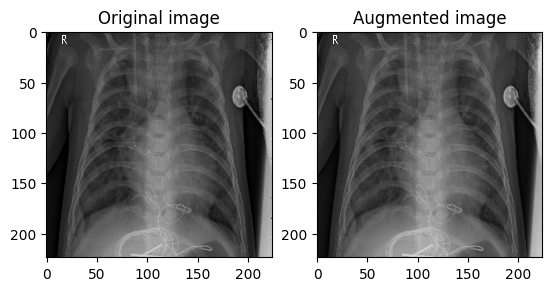

In [ ]:
image_path = '/content/chest_xray/train/PNEUMONIA/person1180_virus_2010.jpeg'
img, label = preprocess_image(image_path,'pneumonia',channels=3)
color_jiter_test = color_jitter(img,seed=3)
visualize(img, color_jiter_test)

In [ ]:
img.shape

TensorShape([224, 224, 3])

In [ ]:
number = train_df.shape[0]
factors = []


for i in range(1, number + 1):
    if number % i == 0:
        factors.append(i)


print("factor to factor distribution", number, "is:", factors)

factor to factor distribution 4099 is: [1, 4099]


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE


batch_size = 32

In [ ]:
def augment_train_image(img, label):

    #img = tf.image.random_flip_left_right(img)
    #img = tf.image.random_flip_up_down(img)
    img= color_jitter(img, seed=3)
    return img, label


def augment_val_image(img, label):

    return img, label

layers_augmentation = tf.keras.Sequential([
            #tf.keras.layers.RandomFlip("horizontal_and_vertical"),
            tf.keras.layers.RandomRotation(0.02),
            tf.keras.layers.RandomZoom(height_factor=(0.05, 0.1),width_factor=(0.05, 0.1)),
        ])

In [ ]:
def prepare(ds, batch_size=32,shuffle=False, layers_aug=False, custom_aug=False):

    ds = ds.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.cache()

    if shuffle:
        ds = ds.shuffle(buffer_size=1000)


    if custom_aug:
        ds = ds.map(augment_train_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if layers_aug:
        ds = ds.map(lambda x, y: (layers_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

    ds = ds.batch(batch_size)
    ds = ds.prefetch(AUTOTUNE)

    return ds

In [ ]:
train_image_paths = train_df['file'].values
train_labels = train_df['label'].values

train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_labels))

train_ds= prepare(train_dataset, batch_size, shuffle=False, custom_aug=True)


val_dataset = tf.data.Dataset.from_tensor_slices((val_df['file'].values, val_df['label'].values))
val_ds = prepare(val_dataset,batch_size, shuffle=False)

test_dataset = tf.data.Dataset.from_tensor_slices((test_df['file'].values, test_df['label'].values))
test_ds = prepare(test_dataset, batch_size, shuffle=False)

In [ ]:
for images, labels in train_ds.take(1):
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch Size: {images.shape[0]}")
    print(f"Labels: {labels}")

Batch of images shape: (32, 224, 224, 3)
Batch Size: 32
Labels: [1 1 1 1 0 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1]


In [ ]:
for images, labels in train_ds.take(1):
    print(images[0,:,:,0])

tf.Tensor(
[[0.15979978 0.16633952 0.17042354 ... 0.14711642 0.14317322 0.13923001]
 [0.166762   0.16633952 0.1736626  ... 0.1514205  0.14964253 0.14277714]
 [0.17394426 0.16633952 0.17690164 ... 0.1550028  0.1510596  0.14711642]
 ...
 [0.09979802 0.09979802 0.09979802 ... 0.07219562 0.07613882 0.07613882]
 [0.09979802 0.09979802 0.09979802 ... 0.07219562 0.07613882 0.07613882]
 [0.09979802 0.09979802 0.09979802 ... 0.07219562 0.07613882 0.07613882]], shape=(224, 224), dtype=float32)


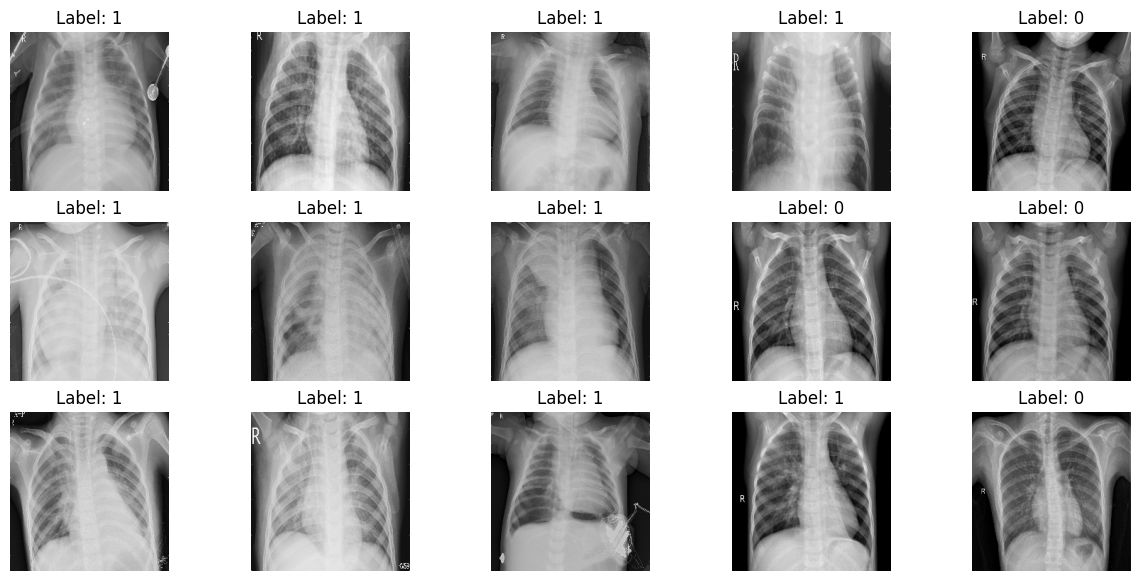

In [ ]:
for images, labels in train_ds.take(1):

    plt.figure(figsize=(15, 7))
    for i in range(15):
        plt.subplot(3, 5, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis('off')
    plt.show()

In [ ]:
# Create the SqueezeNet model
model = densenet(input_shape, numofclasses)

# Display the model summary
model.summary()

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D

In [ ]:
vgg=VGG16(input_shape=(224,224,3) , weights='imagenet' , include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
for layers in vgg.layers:
  layers.trainable=False

In [ ]:
from keras.models import Model

In [ ]:
model_vgg = vgg.output
#model_vgg = GlobalAveragePooling2D()(model_vgg)
model_vgg = Flatten()(model_vgg)
model_vgg = Dense(198,activation='relu')(model_vgg)
model_vgg = Dense(128,activation='relu')(model_vgg)
model_vgg = Dropout(0.2)(model_vgg)
model_vgg = Dense(1,activation='sigmoid')(model_vgg)
model_vgg = Model(inputs=vgg.input,outputs=model_vgg)
model_vgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
model_vgg.compile(optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

In [ ]:
#  learning rate
learning_rate = 0.01  # dafault 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model_vgg.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)
checkpoint = ModelCheckpoint(filepath='./model.h5', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7)

In [ ]:
import time

In [ ]:
start = time.time()
history = model_vgg.fit(train_ds, validation_data=val_ds,
            epochs=14,callbacks =[tensorboard,checkpoint,reduce_lr])
end = time.time()
elapsed = end - start
print("Total Time:", elapsed)

Epoch 1/14
129/129 [==============================] - ETA: 0s - loss: 0.8924 - accuracy: 0.9100
Epoch 1: val_loss improved from inf to 0.12720, saving model to ./model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


129/129 [==============================] - 67s 427ms/step - loss: 0.8924 - accuracy: 0.9100 - val_loss: 0.1272 - val_accuracy: 0.9602 - lr: 0.0100
Epoch 2/14
128/129 [============================>.] - ETA: 0s - loss: 0.1031 - accuracy: 0.9661
Epoch 2: val_loss improved from 0.12720 to 0.12635, saving model to ./model.h5
129/129 [==============================] - 20s 156ms/step - loss: 0.1030 - accuracy: 0.9661 - val_loss: 0.1264 - val_accuracy: 0.9659 - lr: 0.0100
Epoch 3/14
128/129 [============================>.] - ETA: 0s - loss: 0.1261 - accuracy: 0.9580
Epoch 3: val_loss improved from 0.12635 to 0.10950, saving model to ./model.h5
129/129 [==============================] - 23s 176ms/step - loss: 0.1260 - accuracy: 0.9580 - val_loss: 0.1095 - val_accuracy: 0.9636 - lr: 0.0100
Epoch 4/14
128/129 [============================>.] - ETA: 0s - loss: 0.1147 - accuracy: 0.9619
Epoch 4: val_loss did not improve from 0.10950
129/129 [==============================] - 21s 162ms/step - loss: 

In [ ]:
def plot_training_history(history_name=None,start_epoch=1):
    # make sure history_name  None
    if history_name is None:
        raise ValueError("Parameter 'history_name' must be fill with objective (history).")

    # Grab training data from object history
    train_loss, val_loss, train_acc, val_acc=train_val_eval(history_name)
    range_epoch= np.arange(start_epoch, start_epoch + len(train_loss))
    learning_rate = history_name.history['lr']


    # Make a plot for loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range_epoch, train_loss, label='Training Loss',marker='o', color='red')
    plt.plot(range_epoch, val_loss, label='Validation Loss',marker='x',color='blue')
    plt.plot(range_epoch, learning_rate, label='learning_rate',marker='*',color='green')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.xticks(np.arange(start_epoch, start_epoch + len(train_loss), step=2))

    # Create plot for accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range_epoch, train_acc, label='Training Accuracy',marker='o',color='red')
    plt.plot(range_epoch, val_acc, label='Validation Accuracy',marker='x',color='blue')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.xticks(range_epoch)
    plt.xticks(np.arange(start_epoch, start_epoch + len(train_loss), step=2))

    plt.show()

In [ ]:
def train_val_eval(history_name=None):
    train_loss = history_name.history['loss']
    val_loss = history_name.history['val_loss']
    train_acc = history_name.history['accuracy']
    val_acc = history_name.history['val_accuracy']
    return train_loss, val_loss, train_acc, val_acc

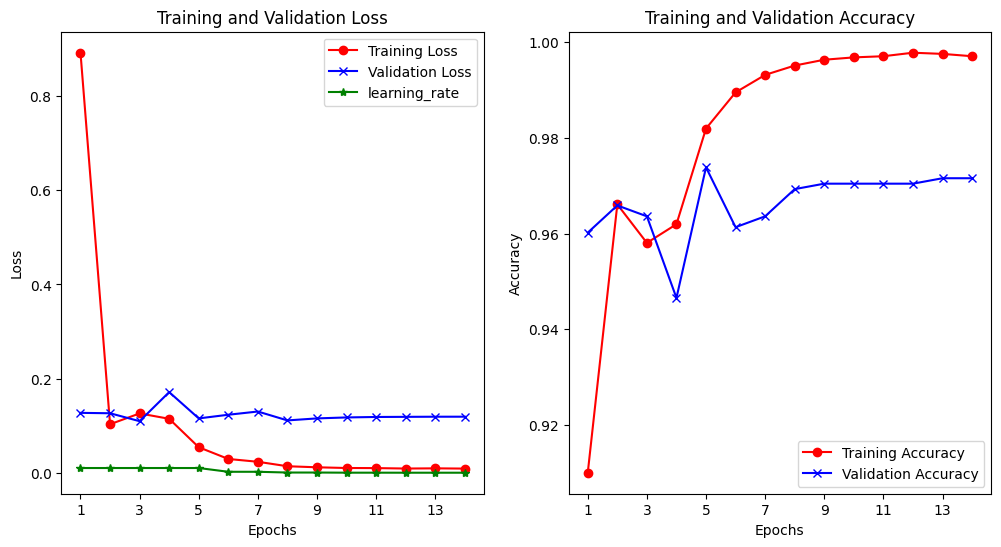

In [ ]:
plot_training_history(history_name=history)

In [ ]:
def evaluate(data=None, model=None):
    loss, acc = model.evaluate(data, verbose=2)
    print("Restored model, accuracy: {:5.2f}%".format(100 * acc))
    print("Restored model, loss: {:5.2f}%".format(100 * loss))

In [ ]:
preds = model_vgg.predict(test_ds)

28/28 [==============================] - 15s 505ms/step


In [ ]:
print(preds)

[[2.22596893e-04]
 [9.99852896e-01]
 [9.99948263e-01]
 [9.99999762e-01]
 [9.99967456e-01]
 [9.99999404e-01]
 [9.99999762e-01]
 [9.99999881e-01]
 [9.99996781e-01]
 [9.99999762e-01]
 [9.99999881e-01]
 [6.48055109e-04]
 [9.99989629e-01]
 [2.89463351e-05]
 [8.65669250e-01]
 [9.99998450e-01]
 [9.99999285e-01]
 [7.62468289e-07]
 [5.97317069e-07]
 [6.95468407e-05]
 [1.00000000e+00]
 [9.99983549e-01]
 [2.48955221e-05]
 [9.99999881e-01]
 [9.99945283e-01]
 [9.99914765e-01]
 [1.70301262e-03]
 [9.99868155e-01]
 [8.93206845e-07]
 [9.99998808e-01]
 [9.99997258e-01]
 [2.32711027e-05]
 [9.69472826e-01]
 [9.99947190e-01]
 [9.99999762e-01]
 [9.99999285e-01]
 [9.08328417e-08]
 [9.93904650e-01]
 [9.99999285e-01]
 [7.81544659e-05]
 [9.99997616e-01]
 [3.43008578e-05]
 [2.22347234e-03]
 [1.48877723e-06]
 [1.86262980e-07]
 [9.99999404e-01]
 [9.99998808e-01]
 [1.64361589e-03]
 [1.83500670e-05]
 [1.21497055e-06]
 [1.00000000e+00]
 [9.99975324e-01]
 [9.98681128e-01]
 [9.99999881e-01]
 [2.38464727e-05]
 [1.458053

In [ ]:
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import auc

fpr , tpr , thresholds = roc_curve ( y_test , preds)
auc_keras = auc(fpr, tpr)
print("AUC Score:",auc_keras)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_keras)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
model_vgg.load_weights(checkpoint)
evaluate(val_ds,model_vgg)

AttributeError: 'ModelCheckpoint' object has no attribute 'endswith'

In [ ]:
evaluate(train_ds,model_vgg)

In [ ]:
evaluate(test_ds,model_vgg)

In [ ]:
model_vgg.save('model_vgg.keras')

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
# Define function to make prediction
def predict_and_evaluate(model, dataset):
    y_true = []
    y_pred = []

    #  Iterate through the dataset to get the actual label and result prediction
    for image, label in dataset:
        predictions = model.predict(image,verbose=0)
        y_true.extend(label.numpy())
        y_pred.extend(np.round(predictions).flatten())

   # classification report
    report = classification_report(y_true, y_pred, target_names=['normal', 'pneumonia'])

    return report

In [ ]:
def calculate_confusion_matrix(model, dataset):
    y_true = []  # Label yang sebenarnya
    y_pred = []  # Label hasil prediksi


    for image, label in dataset:
        predictions = model.predict(image,verbose=0)
        y_true.extend(label.numpy())
        y_pred.extend(np.round(predictions).flatten())

    #  confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    #Plot confusion_matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Normal', 'Pneumonia'],
                yticklabels=['Normal', 'Pneumonia'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


    tn, fp, fn, tp = conf_matrix.ravel()
    #tp = conf_matrix[1, 1]
    #p = conf_matrix[0, 1]
    #tn = conf_matrix[0, 0]
    #fn = conf_matrix[1, 0]

    return tp, fp, tn, fn

In [ ]:
#Load model
loaded_model_4 = tf.keras.models.load_model('model_vgg.keras')
classification_report_result = predict_and_evaluate(loaded_model_4, test_ds)
#  classification report
print(classification_report_result)

              precision    recall  f1-score   support

      normal       0.95      0.95      0.95       237
   pneumonia       0.98      0.98      0.98       641

    accuracy                           0.97       878
   macro avg       0.96      0.96      0.96       878
weighted avg       0.97      0.97      0.97       878



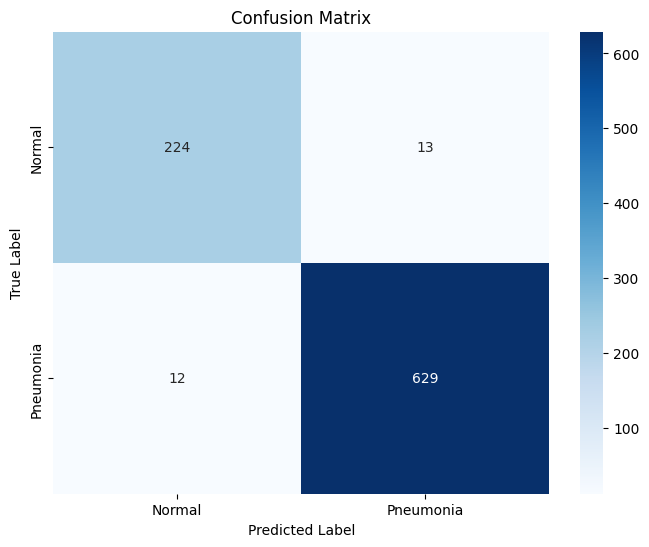

True Positive (TP): 629
False Positive (FP): 13
True Negative (TN): 224
False Negative (FN): 12


In [ ]:
# Increasing confusion matrix by model loading and dataset testing
tp, fp, tn, fn = calculate_confusion_matrix(loaded_model_4, test_ds)
print("True Positive (TP):", tp)
print("False Positive (FP):", fp)
print("True Negative (TN):", tn)
print("False Negative (FN):", fn)

AUC Score: 0.9632134652474706


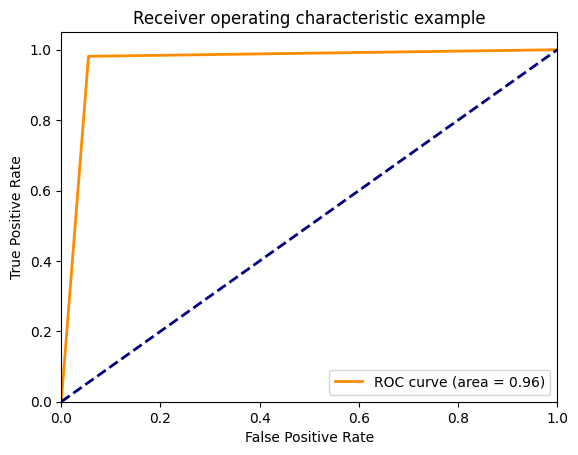

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from keras.models import load_model

y_true = []  # Label yang sebenarnya
y_pred = []  # Label hasil prediksi

for image, label in test_ds:
    predictions = loaded_model_4.predict(image,verbose=0)
    y_true.extend(label.numpy())
    y_pred.extend(np.round(predictions).flatten())
    fpr , tpr , thresholds = roc_curve ( y_true , y_pred)
auc_keras = auc(fpr, tpr)
print("AUC Score:",auc_keras)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_keras)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

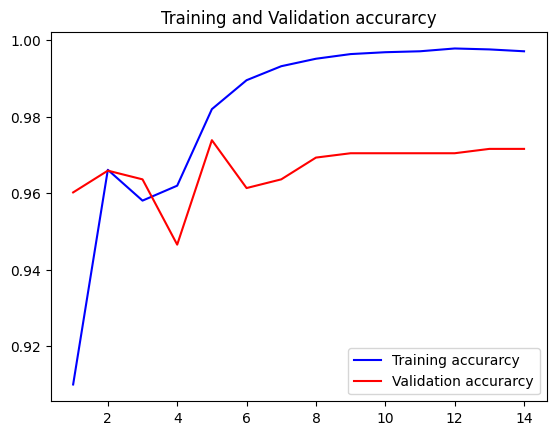

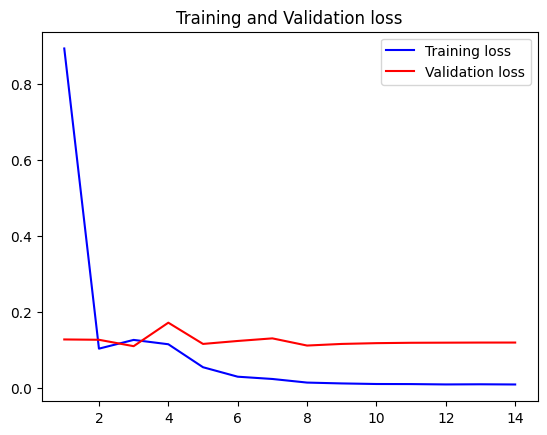

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()


In [ ]:
!pip install pydot
!pip install graphviz
import pydot
import graphviz
from keras.utils import plot_model

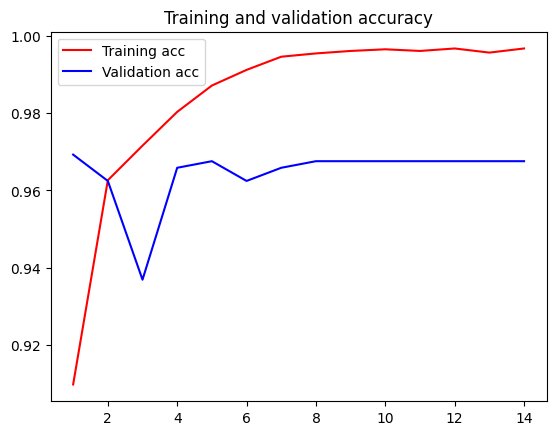

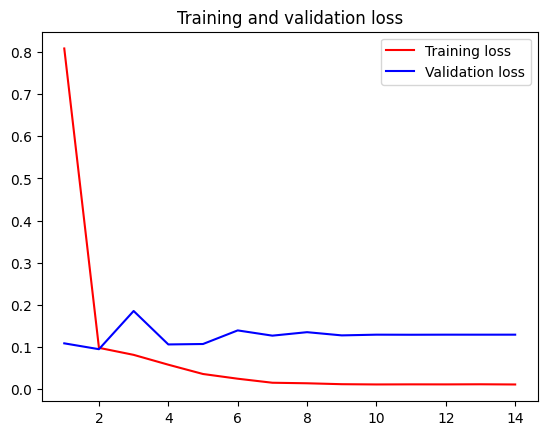

In [ ]:
model_vgg.save('vgg16_model.h5')


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

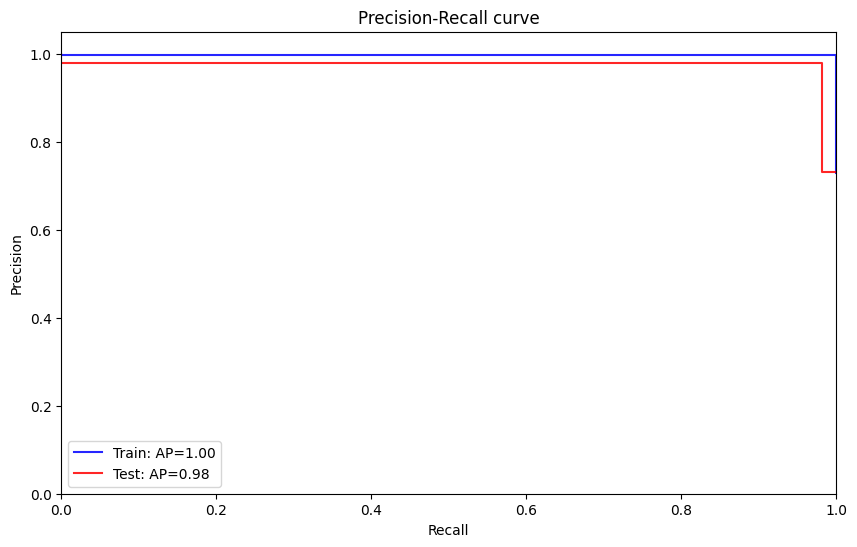

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from keras.models import load_model
y_true = []  # Label yang sebenarnya
y_pred = []  # Label hasil prediksi

for image, label in test_ds:
    predictions = loaded_model_4.predict(image,verbose=0)
    y_true.extend(label.numpy())
    y_pred.extend(np.round(predictions).flatten())

y_traintrue = []  # Label yang sebenarnya
y_trainpred = []  # Label hasil prediksi

for image, label in train_ds:
    predictions = loaded_model_4.predict(image,verbose=0)
    y_traintrue.extend(label.numpy())
    y_trainpred.extend(np.round(predictions).flatten())


# Calculate precision-recall curve for train data
precision_train, recall_train, _ = precision_recall_curve(y_traintrue, y_trainpred)
average_precision_train = average_precision_score(y_traintrue, y_trainpred)

# Calculate precision-recall curve for test data
precision_test, recall_test, _ = precision_recall_curve(y_true, y_pred)
average_precision_test = average_precision_score(y_true, y_pred)

# Plot precision-recall curve
plt.figure(figsize=(10, 6))
plt.step(recall_train, precision_train, color='b', alpha=0.85, where='post', label='Train: AP={0:0.2f}'.format(average_precision_train))
plt.fill_between(recall_train, precision_train, step='post', alpha=0, color='b')
plt.step(recall_test, precision_test, color='r', alpha=0.85, where='post', label='Test: AP={0:0.2f}'.format(average_precision_test))
plt.fill_between(recall_test, precision_test, step='post', alpha=0, color='r')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')
plt.show()

In [ ]:
test_df.sample(19).values[0]

array(['/content/chest_xray/train/PNEUMONIA/person1552_bacteria_4055.jpeg',
       98.588, 'pneumonia', (1136, 864)], dtype=object)

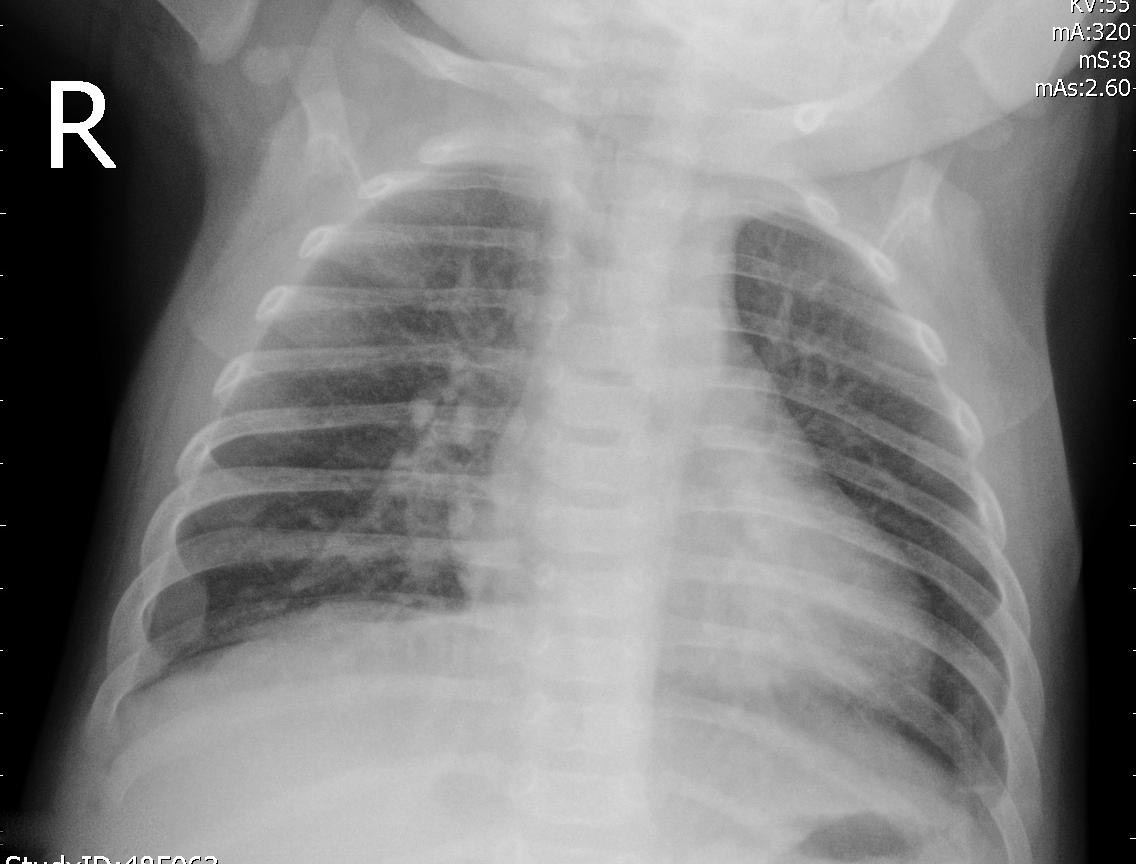

In [ ]:
import tensorflow as tf
from tensorflow import keras
from IPython.display import Image, display
import matplotlib.cm as cm

model_builder = tf.keras.applications.vgg16.VGG16
img_size = (224, 224)
preprocess_input = tf.keras.applications.vgg16.preprocess_input
decode_predictions = tf.keras.applications.vgg16.decode_predictions

last_conv_layer_name = "block5_conv3"

# The local path to our target image
img_path ="/content/chest_xray/train/PNEUMONIA/person1552_bacteria_4055.jpeg"

display(Image(img_path))

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 224x224
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (224, 224, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 224, 224, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

35363/35363 [==============================] - 0s 0us/step
Predicted: [('n01943899', 'conch', 8.924022)]


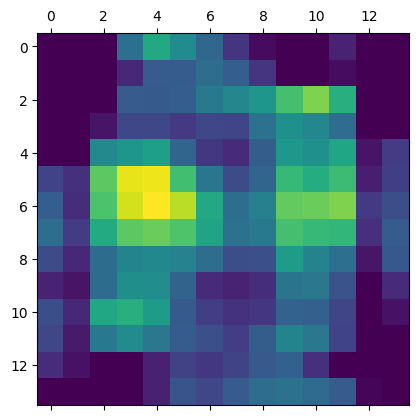

In [ ]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

<ipython-input-90-34e0b9574523>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


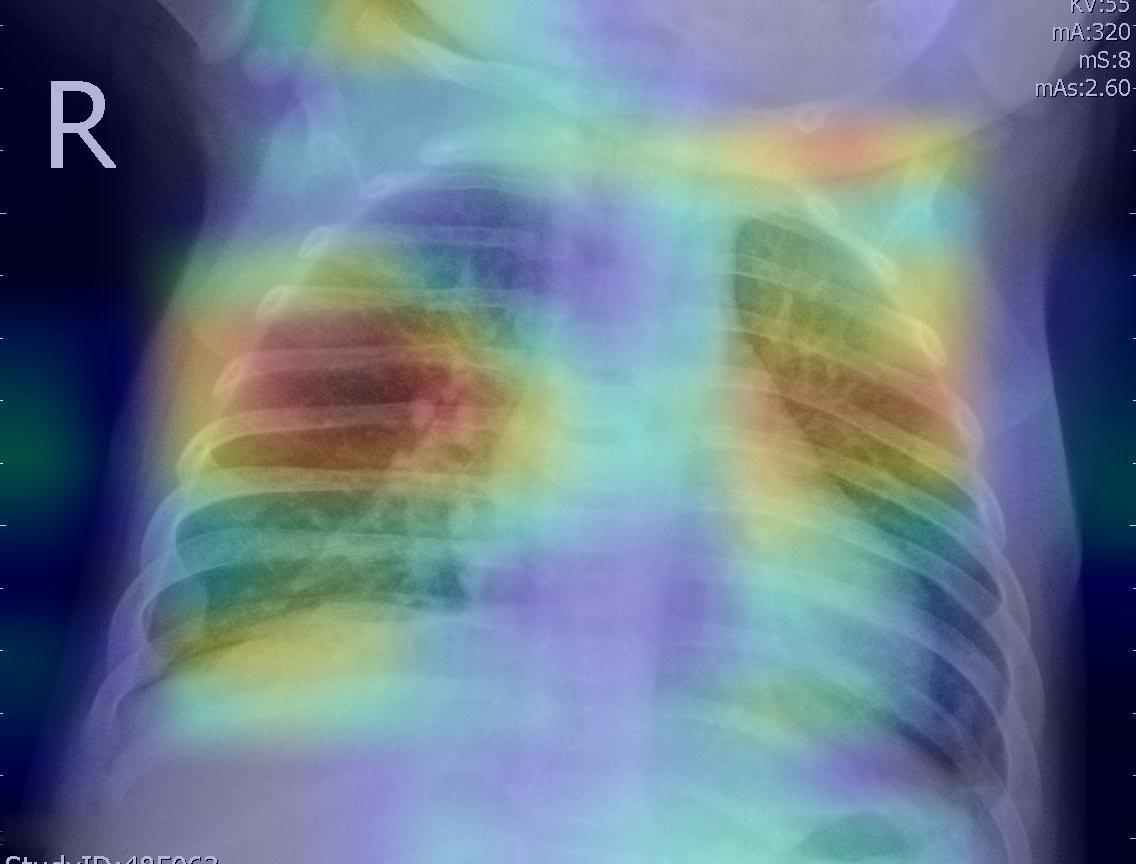

In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

In [ ]:
def evaluate(data=None, model=None):
    loss, acc = model.evaluate(data, verbose=2)
    print("Restored model, accuracy: {:5.2f}%".format(100 * acc))
    print("Restored model, loss: {:5.2f}%".format(100 * loss))

In [ ]:
checkpoint_filepath4 = './model.h5'

In [ ]:
model.load_weights(checkpoint_filepath4)
evaluate(val_ds,model)

ValueError: Cannot assign value to variable ' fc1/kernel:0': Shape mismatch.The variable shape (25088, 4096), and the assigned value shape (25088, 198) are incompatible.

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (224, 224, 3),
                                include_top = False,
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False

# pre_trained_model.summary()


last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

--2024-04-06 19:25:51--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 2607:f8b0:4023:c0d::cf, 2607:f8b0:4023:c06::cf
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   139MB/s    in 0.6s    

2024-04-06 19:25:52 (139 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

last layer output shape:  (None, 12, 12, 768)


In [ ]:
from keras.models import Model, Sequential

In [ ]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.25)(x)
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)


model = Model( pre_trained_model.input, x)

In [ ]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(198, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)


model = Model( pre_trained_model.input, x)

In [ ]:
# Print the model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0]

In [ ]:
#  learning rate
import time
learning_rate = 0.01  # dafault 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
start = time.time()
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
end = time.time()
elapsed = end - start
print("Total Time:", elapsed)

Total Time: 0.014471054077148438


In [ ]:
checkpoint_filepath4 = '/tmp/checkpoint4'
checkpoint_dir4 = os.path.dirname(checkpoint_filepath4)

callbacks_1 = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint(filepath=checkpoint_filepath4, monitor='val_loss',mode='min',
                    save_weights_only=True, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7)
]

In [ ]:
history_1= model.fit(train_ds, validation_data=val_ds,
            epochs=200,
            callbacks=callbacks_1, verbose=1)

Epoch 1/200
129/129 [==============================] - 54s 345ms/step - loss: 2.5221 - accuracy: 0.9041 - val_loss: 0.1473 - val_accuracy: 0.9181 - lr: 0.0100
Epoch 2/200
129/129 [==============================] - 11s 89ms/step - loss: 0.1093 - accuracy: 0.9685 - val_loss: 0.1047 - val_accuracy: 0.9613 - lr: 0.0100
Epoch 3/200
129/129 [==============================] - 10s 80ms/step - loss: 0.0491 - accuracy: 0.9800 - val_loss: 0.1249 - val_accuracy: 0.9568 - lr: 0.0100
Epoch 4/200
129/129 [==============================] - 11s 87ms/step - loss: 0.0687 - accuracy: 0.9768 - val_loss: 0.1933 - val_accuracy: 0.9556 - lr: 0.0100
Epoch 5/200
129/129 [==============================] - 11s 82ms/step - loss: 0.0227 - accuracy: 0.9927 - val_loss: 0.1145 - val_accuracy: 0.9693 - lr: 0.0020
Epoch 6/200
129/129 [==============================] - 10s 76ms/step - loss: 0.0115 - accuracy: 0.9961 - val_loss: 0.1266 - val_accuracy: 0.9716 - lr: 0.0020
Epoch 7/200
129/129 [==============================

In [ ]:
input_shape= (224, 224, 3)

model_1 = tf.keras.models.Sequential([
    #tf.keras.Input(shape=(200, 200, 3)),
    Conv2D(32 , (5,5) , strides = 1 , padding = 'same' , activation = 'relu',input_shape = input_shape),
    Conv2D(32 , (5,5) , strides = 1 , padding = 'same' , activation = 'relu',input_shape = input_shape),
    #BatchNormalization(),
    MaxPool2D((2,2) , strides = 2 , padding = 'valid'),

    Conv2D(64 , (3,3) , strides = 1 , padding = 'valid' , activation = 'relu'),
    #BatchNormalization(),
    MaxPool2D((2,2) , strides = 2 , padding = 'valid'),

    Conv2D(128 , (3,3) , strides = 1 , padding = 'valid' , activation = 'relu'),
    #BatchNormalization(),
    MaxPool2D((2,2) , strides = 2 , padding = 'valid'),
    Dropout(0.5),
    Flatten(),
    Dense(units = 1024 , activation = 'relu'),
    Dropout(0.5),
    Dense(units = 512 , activation = 'relu'),
    Dropout(0.5),
    Dense(units = 1 , activation = 'sigmoid')
])

# Membangun model
# model_1.build(input_shape=(None, 224, 224, 3))

# Menampilkan ringkasan model
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_188 (Conv2D)         (None, 224, 224, 32)      2432      
                                                                 
 conv2d_189 (Conv2D)         (None, 224, 224, 32)      25632     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_190 (Conv2D)         (None, 110, 110, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 55, 55, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_191 (Conv2D)         (None, 53, 53, 128)      

In [ ]:
#  learning rate
learning_rate = 0.01  # dafault 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model_1.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
checkpoint_filepath5 = '/tmp/checkpoint5'
checkpoint_dir5 = os.path.dirname(checkpoint_filepath5)

callbacks_1 = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint(filepath=checkpoint_filepath5, monitor='val_loss',mode='min',
                    save_weights_only=True, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7)
]

In [ ]:
history_1= model_1.fit(train_ds, validation_data=val_ds,
            epochs=200,
            callbacks=callbacks_1, verbose=1)

Epoch 1/200
129/129 [==============================] - 39s 232ms/step - loss: 30.2338 - accuracy: 0.7253 - val_loss: 0.5866 - val_accuracy: 0.7292 - lr: 0.0100
Epoch 2/200
129/129 [==============================] - 27s 206ms/step - loss: 0.5877 - accuracy: 0.7297 - val_loss: 0.5841 - val_accuracy: 0.7292 - lr: 0.0100
Epoch 3/200
129/129 [==============================] - 26s 200ms/step - loss: 0.5874 - accuracy: 0.7297 - val_loss: 0.5841 - val_accuracy: 0.7292 - lr: 0.0100
Epoch 4/200
129/129 [==============================] - 40s 308ms/step - loss: 0.5861 - accuracy: 0.7297 - val_loss: 0.5840 - val_accuracy: 0.7292 - lr: 0.0100
Epoch 5/200
129/129 [==============================] - 21s 162ms/step - loss: 0.5857 - accuracy: 0.7297 - val_loss: 0.5840 - val_accuracy: 0.7292 - lr: 0.0020
Epoch 6/200
129/129 [==============================] - 91s 712ms/step - loss: 0.5850 - accuracy: 0.7297 - val_loss: 0.5840 - val_accuracy: 0.7292 - lr: 0.0020
Epoch 7/200
129/129 [========================

In [ ]:
def plot_training_history(history_name=None,start_epoch=1):
    # make sure history_name  None
    if history_name is None:
        raise ValueError("Parameter 'history_name' must be fill with objective (history).")

    # Grab training data from object history
    train_loss, val_loss, train_acc, val_acc=train_val_eval(history_name)
    range_epoch= np.arange(start_epoch, start_epoch + len(train_loss))
    learning_rate = history_name.history['lr']


    # Make a plot for loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range_epoch, train_loss, label='Training Loss',marker='o', color='red')
    plt.plot(range_epoch, val_loss, label='Validation Loss',marker='x',color='blue')
    plt.plot(range_epoch, learning_rate, label='learning_rate',marker='*',color='green')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.xticks(np.arange(start_epoch, start_epoch + len(train_loss), step=2))

    # Create plot for accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range_epoch, train_acc, label='Training Accuracy',marker='o',color='red')
    plt.plot(range_epoch, val_acc, label='Validation Accuracy',marker='x',color='blue')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.xticks(range_epoch)
    plt.xticks(np.arange(start_epoch, start_epoch + len(train_loss), step=2))

    plt.show()

In [ ]:
def train_val_eval(history_name=None):
    train_loss = history_name.history['loss']
    val_loss = history_name.history['val_loss']
    train_acc = history_name.history['accuracy']
    val_acc = history_name.history['val_accuracy']
    return train_loss, val_loss, train_acc, val_acc

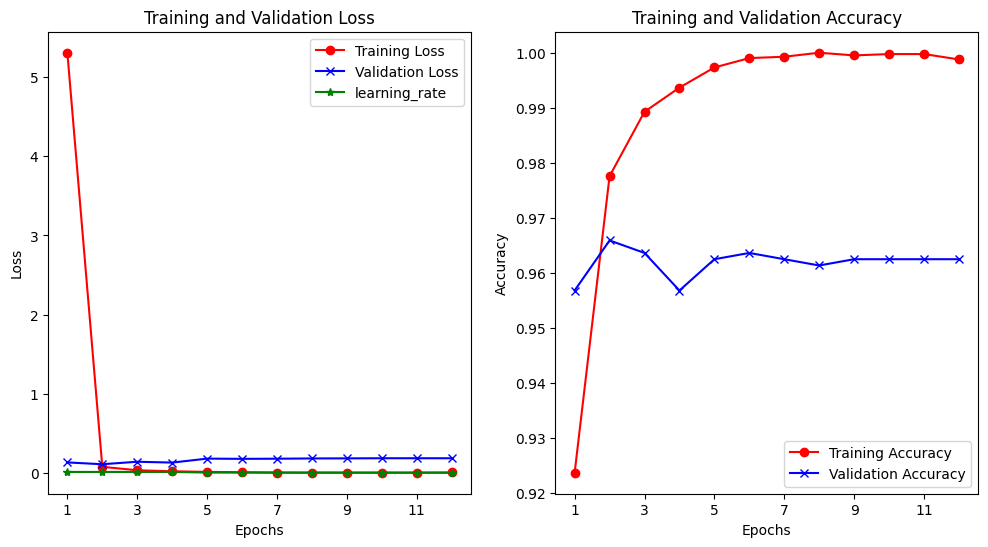

In [ ]:
plot_training_history(history_name=history_1)

In [ ]:
def evaluate(data=None, model=None):
    loss, acc = model.evaluate(data, verbose=2)
    print("Restored model, accuracy: {:5.2f}%".format(100 * acc))
    print("Restored model, loss: {:5.2f}%".format(100 * loss))

In [ ]:
model.load_weights(checkpoint_filepath4)
start = time.time()
evaluate(val_ds,model)
end = time.time()
elapsed = end - start
print("Total Time:", elapsed)

28/28 - 2s - loss: 0.1047 - accuracy: 0.9613 - 2s/epoch - 64ms/step
Restored model, accuracy: 96.13%
Restored model, loss: 10.47%
Total Time: 2.5614633560180664


In [ ]:
start = time.time()
evaluate(train_ds,model)
end = time.time()
elapsed = end - start
print("Total Time:", elapsed)

129/129 - 8s - loss: 0.0497 - accuracy: 0.9778 - 8s/epoch - 64ms/step
Restored model, accuracy: 97.78%
Restored model, loss:  4.97%
Total Time: 10.28770399093628


In [ ]:
start = time.time()
evaluate(test_ds,model)
end = time.time()
elapsed = end - start
print("Total Time:", elapsed)

28/28 - 9s - loss: 0.1167 - accuracy: 0.9544 - 9s/epoch - 314ms/step
Restored model, accuracy: 95.44%
Restored model, loss: 11.67%
Total Time: 8.818994045257568


In [ ]:
model.save('model.keras')

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
# Define function to make prediction
def predict_and_evaluate(model, dataset):
    y_true = []
    y_pred = []

    #  Iterate through the dataset to get the actual label and result prediction
    for image, label in dataset:
        predictions = model.predict(image,verbose=0)
        y_true.extend(label.numpy())
        y_pred.extend(np.round(predictions).flatten())

   # classification report
    report = classification_report(y_true, y_pred, target_names=['normal', 'pneumonia'])

    return report

In [ ]:
def calculate_confusion_matrix(model, dataset):
    y_true = []  # Label yang sebenarnya
    y_pred = []  # Label hasil prediksi


    for image, label in dataset:
        predictions = model.predict(image,verbose=0)
        y_true.extend(label.numpy())
        y_pred.extend(np.round(predictions).flatten())

    #  confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    #Plot confusion_matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Normal', 'Pneumonia'],
                yticklabels=['Normal', 'Pneumonia'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


    tn, fp, fn, tp = conf_matrix.ravel()
    #tp = conf_matrix[1, 1]
    #p = conf_matrix[0, 1]
    #tn = conf_matrix[0, 0]
    #fn = conf_matrix[1, 0]

    return tp, fp, tn, fn

In [ ]:
#Load model
loaded_model_1 = tf.keras.models.load_model('model.keras')
classification_report_result = predict_and_evaluate(loaded_model_1, test_ds)
#  classification report
print(classification_report_result)

              precision    recall  f1-score   support

      normal       0.95      0.93      0.94       237
   pneumonia       0.97      0.98      0.98       641

    accuracy                           0.97       878
   macro avg       0.96      0.96      0.96       878
weighted avg       0.97      0.97      0.97       878



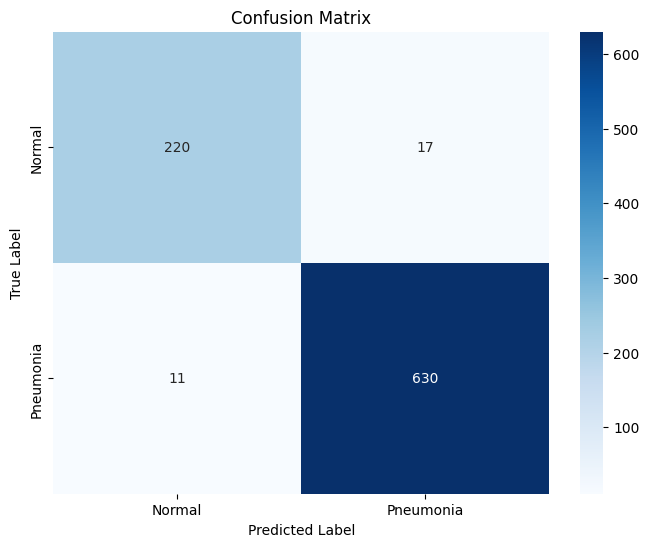

True Positive (TP): 630
False Positive (FP): 17
True Negative (TN): 220
False Negative (FN): 11


In [ ]:
# Increasing confusion matrix by model loading and dataset testing
tp, fp, tn, fn = calculate_confusion_matrix(loaded_model_1, test_ds)
print("True Positive (TP):", tp)
print("False Positive (FP):", fp)
print("True Negative (TN):", tn)
print("False Negative (FN):", fn)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from keras.models import load_model

y_true = []  # Label yang sebenarnya
y_pred = []  # Label hasil prediksi

for image, label in test_ds:
    predictions = loaded_model_1.predict(image,verbose=0)
    y_true.extend(label.numpy())
    y_pred.extend(np.round(predictions).flatten())

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

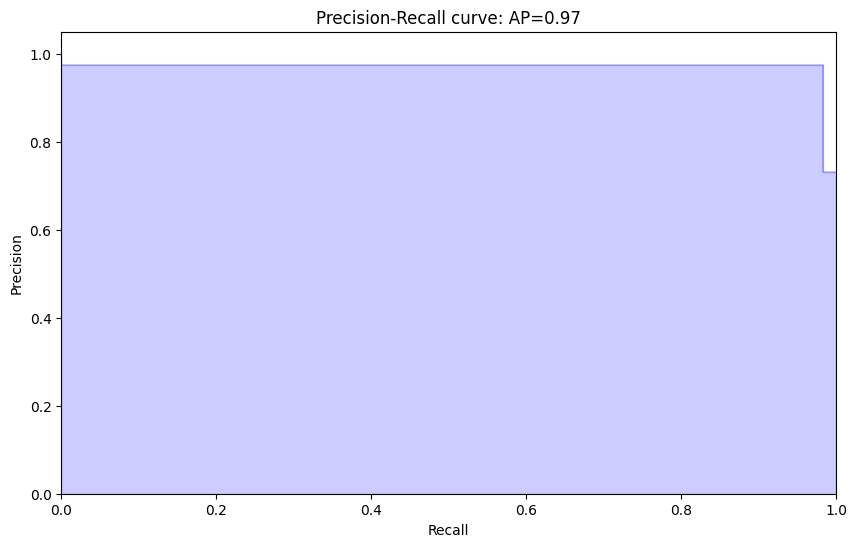

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from keras.models import load_model

y_true = []  # Label yang sebenarnya
y_pred = []  # Label hasil prediksi

for image, label in test_ds:
    predictions = loaded_model_1.predict(image,verbose=0)
    y_true.extend(label.numpy())
    y_pred.extend(np.round(predictions).flatten())
# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(y_true, y_pred)

# Calculate average precision
average_precision = average_precision_score(y_true, y_pred)

# Plot precision-recall curve
plt.figure(figsize=(10, 6))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.show()

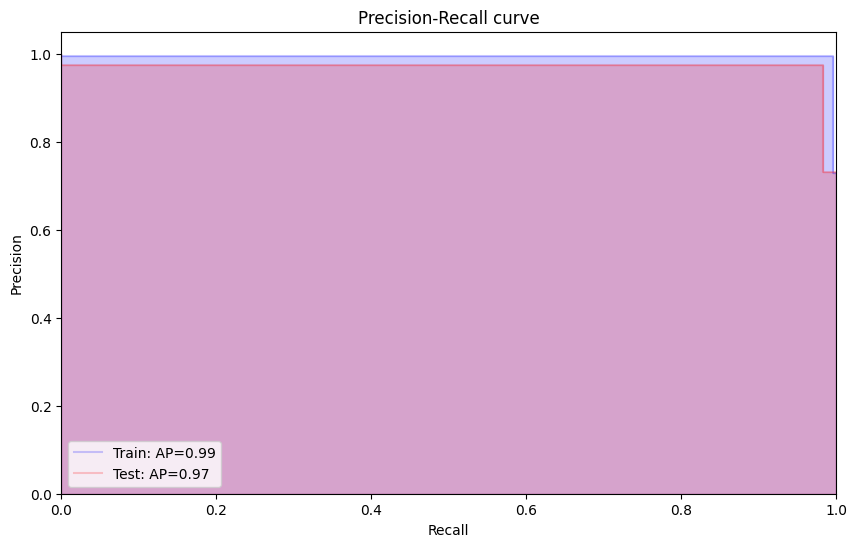

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from keras.models import load_model
y_true = []  # Label yang sebenarnya
y_pred = []  # Label hasil prediksi

for image, label in test_ds:
    predictions = loaded_model_1.predict(image,verbose=0)
    y_true.extend(label.numpy())
    y_pred.extend(np.round(predictions).flatten())

y_traintrue = []  # Label yang sebenarnya
y_trainpred = []  # Label hasil prediksi

for image, label in train_ds:
    predictions = loaded_model_1.predict(image,verbose=0)
    y_traintrue.extend(label.numpy())
    y_trainpred.extend(np.round(predictions).flatten())


# Calculate precision-recall curve for train data
precision_train, recall_train, _ = precision_recall_curve(y_traintrue, y_trainpred)
average_precision_train = average_precision_score(y_traintrue, y_trainpred)

# Calculate precision-recall curve for test data
precision_test, recall_test, _ = precision_recall_curve(y_true, y_pred)
average_precision_test = average_precision_score(y_true, y_pred)

# Plot precision-recall curve
plt.figure(figsize=(10, 6))
plt.step(recall_train, precision_train, color='b', alpha=0.2, where='post', label='Train: AP={0:0.2f}'.format(average_precision_train))
plt.fill_between(recall_train, precision_train, step='post', alpha=0.2, color='b')
plt.step(recall_test, precision_test, color='r', alpha=0.2, where='post', label='Test: AP={0:0.2f}'.format(average_precision_test))
plt.fill_between(recall_test, precision_test, step='post', alpha=0.2, color='r')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')
plt.show()


In [ ]:
def squeezenet(input_shape, numofclasses):

  def fire(x, fs, fe):
    s = Conv2D(fs, 1, activation='relu')(x)
    e1 = Conv2D(fe, 1, activation='relu')(s)
    e3 = Conv2D(fe, 3, padding='same', activation='relu')(s)
    output = Concatenate()([e1, e3])
    return output
  input = Input(input_shape)
  x = Conv2D(96, 7, strides=2, padding='same', activation='relu')(input)
  x = MaxPool2D(3, strides=2, padding='same')(x)

  x = fire(x, 16, 64)
  x = fire(x, 16, 64)
  x = fire(x, 32, 128)
  x = MaxPool2D(3, strides=2, padding='same')(x)
  x = fire(x, 32, 128)
  x = fire(x, 48, 192)
  x = fire(x, 48, 192)
  x = fire(x, 64, 256)
  x = MaxPool2D(3, strides=2, padding='same')(x)

  x = fire(x, 64, 256)
  x = Conv2D(numofclasses, 1)(x)
  x = GlobalAvgPool2D()(x)

  output = Activation('sigmoid')(x)

  model = Model(input, output)
  return model


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Concatenate, GlobalAvgPool2D, Activation

input_shape= (224, 224, 3)

# Create the SqueezeNet model
model_2 = squeezenet(input_shape, 1)

# Display the model summary
model_2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 112, 112, 96)         14208     ['input_2[0][0]']             
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 56, 56, 96)           0         ['conv2d_94[0][0]']           
 g2D)                                                                                             
                                                                                                  
 conv2d_95 (Conv2D)          (None, 56, 56, 16)           1552      ['max_pooling2d_4[0][0]'] 

In [ ]:
#  learning rate
learning_rate = 0.01  # dafault 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model_2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
checkpoint_filepath5 = '/tmp/checkpoint5'
checkpoint_dir5 = os.path.dirname(checkpoint_filepath5)

callbacks_1 = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ModelCheckpoint(filepath=checkpoint_filepath5, monitor='val_loss',mode='min',
                    save_weights_only=True, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7)
]

In [ ]:
history_2= model_2.fit(train_ds, validation_data=val_ds,
            epochs=200,
            callbacks=callbacks_1, verbose=1)

Epoch 1/200
129/129 [==============================] - 59s 344ms/step - loss: 9.7898 - accuracy: 0.7248 - val_loss: 0.5884 - val_accuracy: 0.7292 - lr: 0.0100
Epoch 2/200
129/129 [==============================] - 12s 89ms/step - loss: 0.5850 - accuracy: 0.7297 - val_loss: 0.5852 - val_accuracy: 0.7292 - lr: 0.0100
Epoch 3/200
129/129 [==============================] - 12s 89ms/step - loss: 0.5847 - accuracy: 0.7297 - val_loss: 0.5848 - val_accuracy: 0.7292 - lr: 0.0100
Epoch 4/200
129/129 [==============================] - 11s 88ms/step - loss: 0.5846 - accuracy: 0.7297 - val_loss: 0.5845 - val_accuracy: 0.7292 - lr: 0.0100
Epoch 5/200
129/129 [==============================] - 12s 89ms/step - loss: 0.5845 - accuracy: 0.7297 - val_loss: 0.5843 - val_accuracy: 0.7292 - lr: 0.0100
Epoch 6/200
129/129 [==============================] - 12s 89ms/step - loss: 0.5845 - accuracy: 0.7297 - val_loss: 0.5841 - val_accuracy: 0.7292 - lr: 0.0100
Epoch 7/200
129/129 [==============================

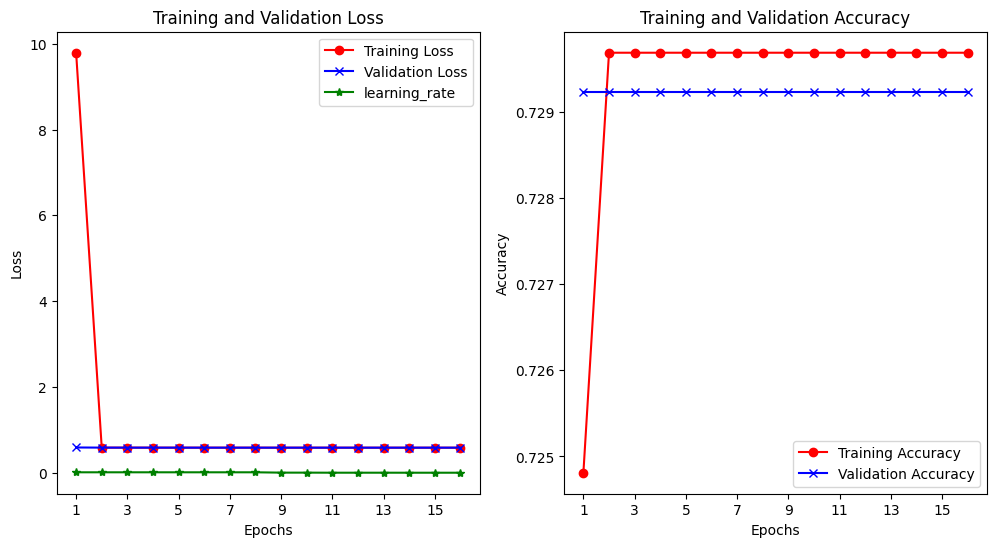

In [ ]:
plot_training_history(history_name=history_2)

In [ ]:
model_2.load_weights(checkpoint_filepath5)
evaluate(val_ds,model_2)

28/28 - 1s - loss: 0.5840 - accuracy: 0.7292 - 951ms/epoch - 34ms/step
Restored model, accuracy: 72.92%
Restored model, loss: 58.40%


In [ ]:
evaluate(train_ds,model_2)

129/129 - 5s - loss: 0.5836 - accuracy: 0.7297 - 5s/epoch - 38ms/step
Restored model, accuracy: 72.97%
Restored model, loss: 58.36%


In [ ]:
evaluate(test_ds,model_2)

28/28 - 8s - loss: 0.5832 - accuracy: 0.7301 - 8s/epoch - 276ms/step
Restored model, accuracy: 73.01%
Restored model, loss: 58.32%


In [ ]:
model_2.save('model_2.keras')

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
# Define function to make prediction
def predict_and_evaluate(model, dataset):
    y_true = []
    y_pred = []

    #  Iterate through the dataset to get the actual label and result prediction
    for image, label in dataset:
        predictions = model.predict(image,verbose=0)
        y_true.extend(label.numpy())
        y_pred.extend(np.round(predictions).flatten())

   # classification report
    report = classification_report(y_true, y_pred, target_names=['normal', 'pneumonia'])

    return report

In [ ]:
def calculate_confusion_matrix(model, dataset):
    y_true = []  # Label yang sebenarnya
    y_pred = []  # Label hasil prediksi


    for image, label in dataset:
        predictions = model.predict(image,verbose=0)
        y_true.extend(label.numpy())
        y_pred.extend(np.round(predictions).flatten())

    #  confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    #Plot confusion_matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Normal', 'Pneumonia'],
                yticklabels=['Normal', 'Pneumonia'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


    tn, fp, fn, tp = conf_matrix.ravel()
    #tp = conf_matrix[1, 1]
    #p = conf_matrix[0, 1]
    #tn = conf_matrix[0, 0]
    #fn = conf_matrix[1, 0]

    return tp, fp, tn, fn

In [ ]:
#Load model
loaded_model_2 = tf.keras.models.load_model('model_2.keras')
classification_report_result = predict_and_evaluate(loaded_model_2, test_ds)
#  classification report
print(classification_report_result)

              precision    recall  f1-score   support

      normal       0.00      0.00      0.00       237
   pneumonia       0.73      1.00      0.84       641

    accuracy                           0.73       878
   macro avg       0.37      0.50      0.42       878
weighted avg       0.53      0.73      0.62       878



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


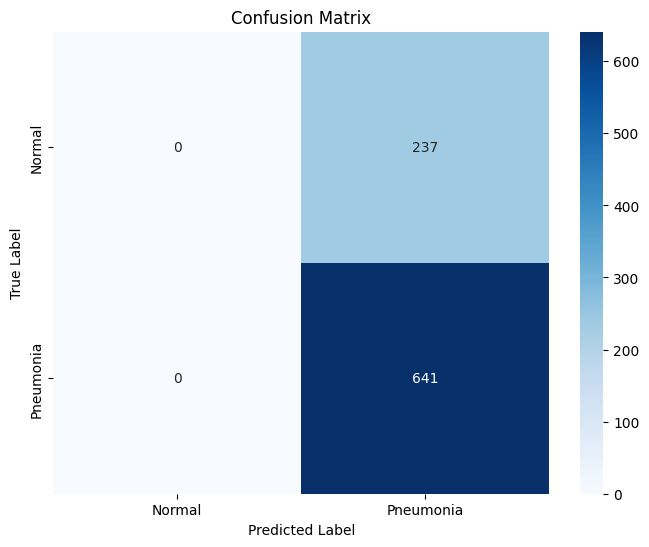

True Positive (TP): 641
False Positive (FP): 237
True Negative (TN): 0
False Negative (FN): 0


In [ ]:
# Increasing confusion matrix by model loading and dataset testing
tp, fp, tn, fn = calculate_confusion_matrix(loaded_model_2, test_ds)
print("True Positive (TP):", tp)
print("False Positive (FP):", fp)
print("True Negative (TN):", tn)
print("False Negative (FN):", fn)

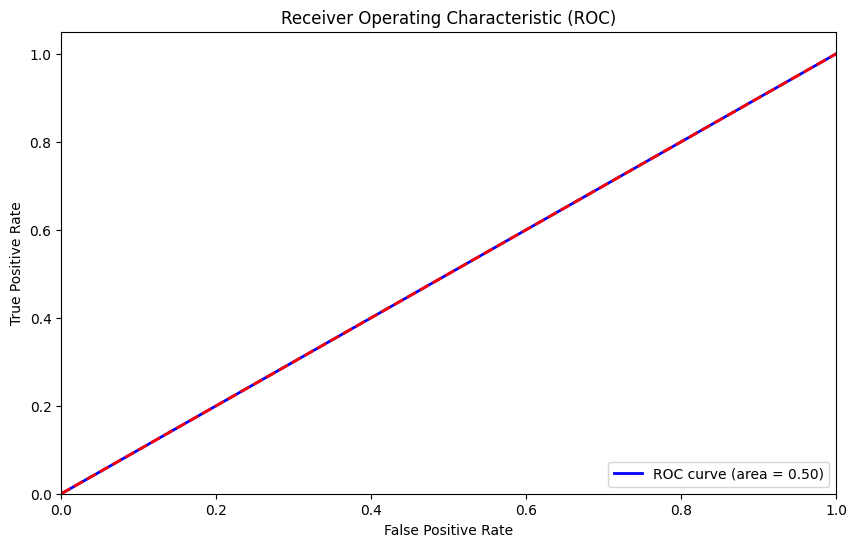

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from keras.models import load_model

y_true = []  # Label yang sebenarnya
y_pred = []  # Label hasil prediksi

for image, label in test_ds:
    predictions = loaded_model_2.predict(image,verbose=0)
    y_true.extend(label.numpy())
    y_pred.extend(np.round(predictions).flatten())

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

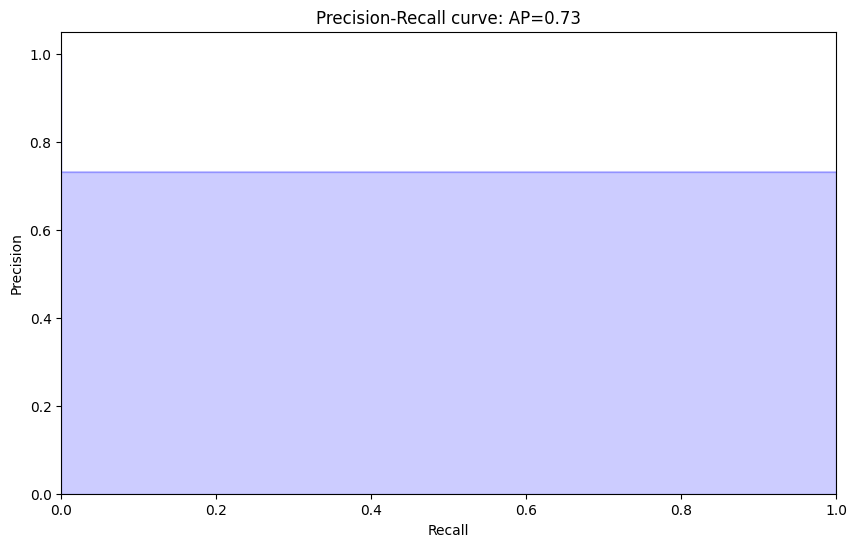

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from keras.models import load_model

y_true = []  # Label yang sebenarnya
y_pred = []  # Label hasil prediksi

for image, label in test_ds:
    predictions = loaded_model_2.predict(image,verbose=0)
    y_true.extend(label.numpy())
    y_pred.extend(np.round(predictions).flatten())
# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(y_true, y_pred)

# Calculate average precision
average_precision = average_precision_score(y_true, y_pred)

# Plot precision-recall curve
plt.figure(figsize=(10, 6))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.show()

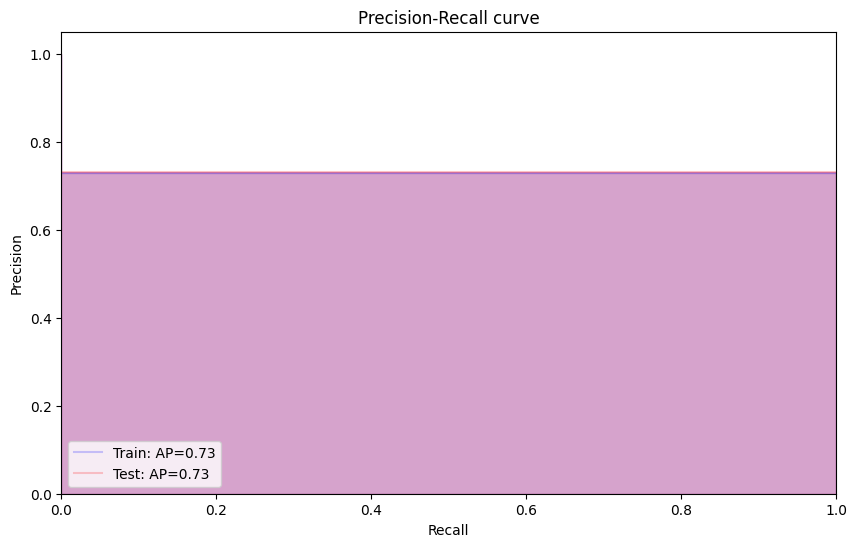

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from keras.models import load_model
y_true = []  # Label yang sebenarnya
y_pred = []  # Label hasil prediksi

for image, label in test_ds:
    predictions = loaded_model_2.predict(image,verbose=0)
    y_true.extend(label.numpy())
    y_pred.extend(np.round(predictions).flatten())

y_traintrue = []  # Label yang sebenarnya
y_trainpred = []  # Label hasil prediksi

for image, label in train_ds:
    predictions = loaded_model_2.predict(image,verbose=0)
    y_traintrue.extend(label.numpy())
    y_trainpred.extend(np.round(predictions).flatten())


# Calculate precision-recall curve for train data
precision_train, recall_train, _ = precision_recall_curve(y_traintrue, y_trainpred)
average_precision_train = average_precision_score(y_traintrue, y_trainpred)

# Calculate precision-recall curve for test data
precision_test, recall_test, _ = precision_recall_curve(y_true, y_pred)
average_precision_test = average_precision_score(y_true, y_pred)

# Plot precision-recall curve
plt.figure(figsize=(10, 6))
plt.step(recall_train, precision_train, color='b', alpha=0.2, where='post', label='Train: AP={0:0.2f}'.format(average_precision_train))
plt.fill_between(recall_train, precision_train, step='post', alpha=0.2, color='b')
plt.step(recall_test, precision_test, color='r', alpha=0.2, where='post', label='Test: AP={0:0.2f}'.format(average_precision_test))
plt.fill_between(recall_test, precision_test, step='post', alpha=0.2, color='r')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')
plt.show()


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, MaxPool2D, GlobalAvgPool2D, Dense, Add
from tensorflow.keras.models import Model

def resnet(input_shape, numofclasses):

  def conv_bn_rl(x, f, k=1, s=1, p='same'):
    x = Conv2D(f, k, strides=s, padding=p)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x


  def identity_block(tensor, f):
    x = conv_bn_rl(tensor, f)
    x = conv_bn_rl(x, f, 3)
    x = Conv2D(4*f, 1)(x)
    x = BatchNormalization()(x)

    x = Add()([x, tensor])
    output = ReLU()(x)
    return output


  def conv_block(tensor, f, s):
    x = conv_bn_rl(tensor, f)
    x = conv_bn_rl(x, f, 3, s)
    x = Conv2D(4*f, 1)(x)
    x = BatchNormalization()(x)

    shortcut = Conv2D(4*f, 1, strides=s)(tensor)
    shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    output = ReLU()(x)
    return output


  def resnet_block(x, f, r, s=2):
    x = conv_block(x, f, s)
    for _ in range(r-1):
      x = identity_block(x, f)
    return x


  input = Input(input_shape)

  x = conv_bn_rl(input, 64, 7, 2)
  x = MaxPool2D(3, strides=2, padding='same')(x)

  x = resnet_block(x, 64, 3, 1)
  x = resnet_block(x, 128, 4)
  x = resnet_block(x, 256, 6)
  x = resnet_block(x, 512, 3)

  x = GlobalAvgPool2D()(x)

  output = Dense(1, activation='sigmoid')(x)

  model = Model(input, output)
  return model

In [ ]:
input_shape= (224, 224, 3)
# Create the SqueezeNet model
model_3 = resnet(input_shape, 1)

# Display the model summary
model_3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 64)         9472      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 112, 112, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 112, 112, 64)         0         ['batch_normalization[0][0

In [ ]:
#  learning rate
learning_rate = 0.01  # dafault 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model_3.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
checkpoint_filepath6 = '/tmp/checkpoint6'
checkpoint_dir6 = os.path.dirname(checkpoint_filepath6)

callbacks_2 = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ModelCheckpoint(filepath=checkpoint_filepath6, monitor='val_loss',mode='min',
                    save_weights_only=True, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7)
]

In [ ]:
history_4= model_3.fit(train_ds, validation_data=val_ds,
            epochs=200,
            callbacks=callbacks_2, verbose=1)

Epoch 1/200
129/129 [==============================] - 95s 444ms/step - loss: 0.6666 - accuracy: 0.7941 - val_loss: 482.8689 - val_accuracy: 0.7292 - lr: 0.0100
Epoch 2/200
129/129 [==============================] - 52s 400ms/step - loss: 0.2844 - accuracy: 0.8807 - val_loss: 19.7146 - val_accuracy: 0.7292 - lr: 0.0100
Epoch 3/200
129/129 [==============================] - 52s 399ms/step - loss: 0.2674 - accuracy: 0.8868 - val_loss: 4.6479 - val_accuracy: 0.7941 - lr: 0.0100
Epoch 4/200
129/129 [==============================] - 50s 389ms/step - loss: 0.2592 - accuracy: 0.8949 - val_loss: 105.9020 - val_accuracy: 0.7292 - lr: 0.0100
Epoch 5/200
129/129 [==============================] - 54s 416ms/step - loss: 0.2235 - accuracy: 0.9085 - val_loss: 1.0898 - val_accuracy: 0.7782 - lr: 0.0100
Epoch 6/200
129/129 [==============================] - 52s 402ms/step - loss: 0.1880 - accuracy: 0.9271 - val_loss: 0.6562 - val_accuracy: 0.7349 - lr: 0.0100
Epoch 7/200
129/129 [====================

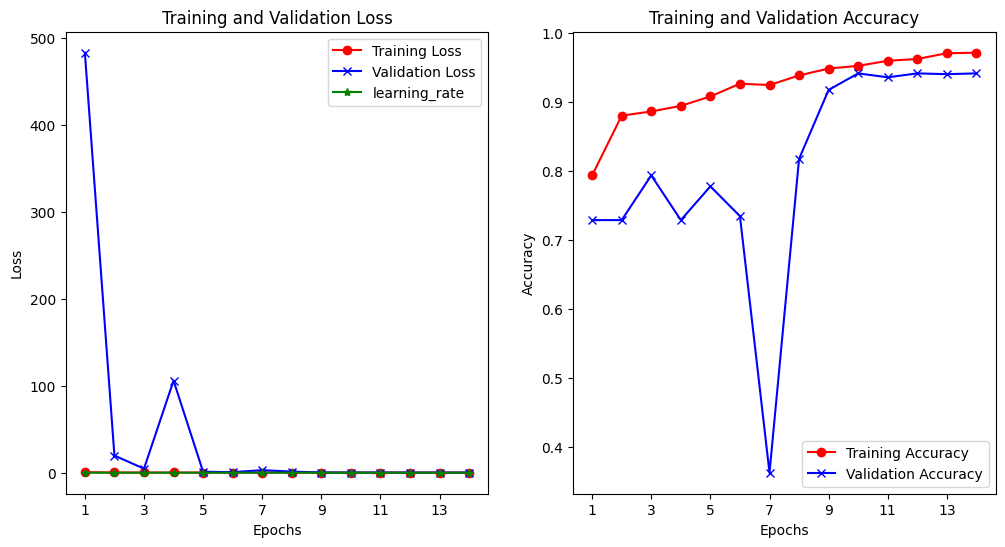

In [ ]:
plot_training_history(history_name=history_4)

In [ ]:
model_3.load_weights(checkpoint_filepath6)
evaluate(val_ds,model_3)

28/28 - 3s - loss: 0.1618 - accuracy: 0.9420 - 3s/epoch - 103ms/step
Restored model, accuracy: 94.20%
Restored model, loss: 16.18%


In [ ]:
evaluate(test_ds,model_3)

28/28 - 5s - loss: 0.1329 - accuracy: 0.9476 - 5s/epoch - 168ms/step
Restored model, accuracy: 94.76%
Restored model, loss: 13.29%


In [ ]:
model_3.save('model_3.keras')

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
# Define function to make prediction
def predict_and_evaluate(model, dataset):
    y_true = []
    y_pred = []

    #  Iterate through the dataset to get the actual label and result prediction
    for image, label in dataset:
        predictions = model.predict(image,verbose=0)
        y_true.extend(label.numpy())
        y_pred.extend(np.round(predictions).flatten())

   # classification report
    report = classification_report(y_true, y_pred, target_names=['normal', 'pneumonia'])

    return report

In [ ]:
def calculate_confusion_matrix(model, dataset):
    y_true = []  # Label yang sebenarnya
    y_pred = []  # Label hasil prediksi


    for image, label in dataset:
        predictions = model.predict(image,verbose=0)
        y_true.extend(label.numpy())
        y_pred.extend(np.round(predictions).flatten())

    #  confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    #Plot confusion_matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Normal', 'Pneumonia'],
                yticklabels=['Normal', 'Pneumonia'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


    tn, fp, fn, tp = conf_matrix.ravel()
    #tp = conf_matrix[1, 1]
    #p = conf_matrix[0, 1]
    #tn = conf_matrix[0, 0]
    #fn = conf_matrix[1, 0]

    return tp, fp, tn, fn

In [ ]:
#Load model
loaded_model_3 = tf.keras.models.load_model('model_3.keras')
classification_report_result = predict_and_evaluate(loaded_model_3, test_ds)
#  classification report
print(classification_report_result)

              precision    recall  f1-score   support

      normal       0.94      0.86      0.90       237
   pneumonia       0.95      0.98      0.96       641

    accuracy                           0.95       878
   macro avg       0.94      0.92      0.93       878
weighted avg       0.95      0.95      0.95       878



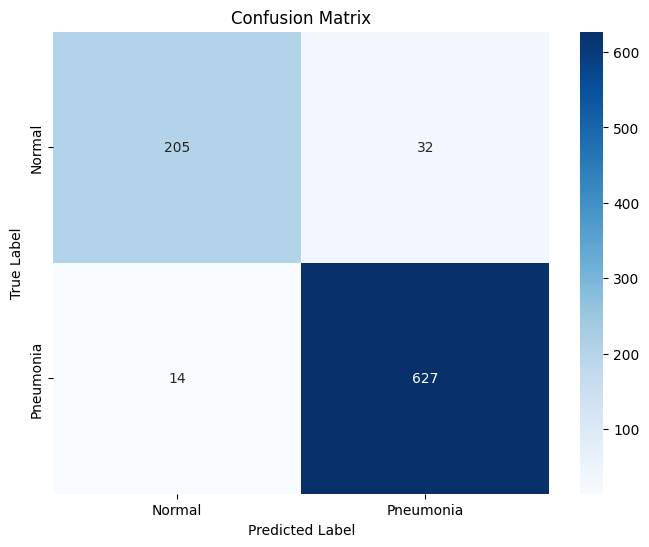

True Positive (TP): 627
False Positive (FP): 32
True Negative (TN): 205
False Negative (FN): 14


In [ ]:
# Increasing confusion matrix by model loading and dataset testing
tp, fp, tn, fn = calculate_confusion_matrix(loaded_model_3, test_ds)
print("True Positive (TP):", tp)
print("False Positive (FP):", fp)
print("True Negative (TN):", tn)
print("False Negative (FN):", fn)

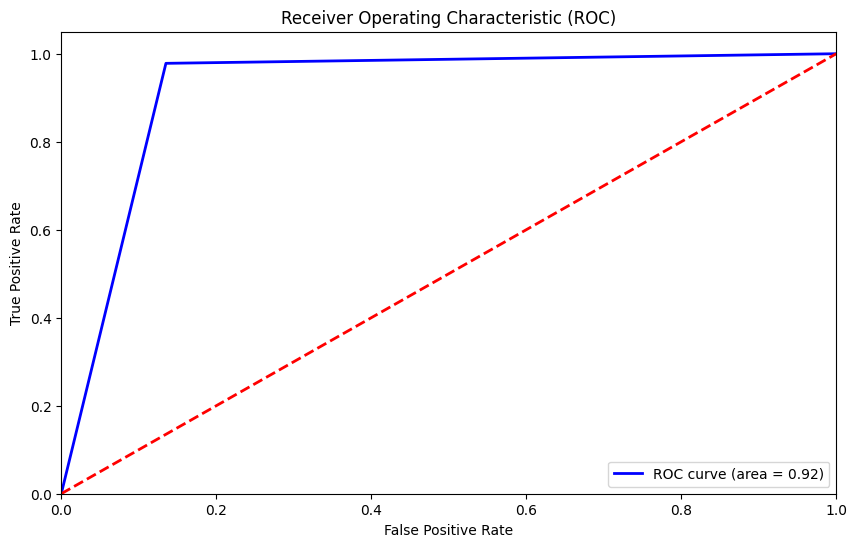

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from keras.models import load_model

y_true = []  # Label yang sebenarnya
y_pred = []  # Label hasil prediksi

for image, label in test_ds:
    predictions = loaded_model_3.predict(image,verbose=0)
    y_true.extend(label.numpy())
    y_pred.extend(np.round(predictions).flatten())

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

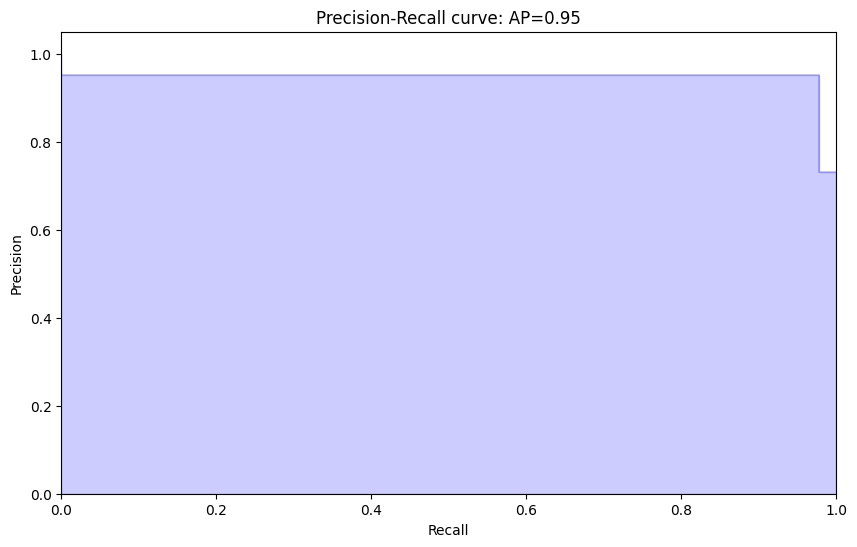

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from keras.models import load_model

y_true = []  # Label yang sebenarnya
y_pred = []  # Label hasil prediksi

for image, label in test_ds:
    predictions = loaded_model_3.predict(image,verbose=0)
    y_true.extend(label.numpy())
    y_pred.extend(np.round(predictions).flatten())
# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(y_true, y_pred)

# Calculate average precision
average_precision = average_precision_score(y_true, y_pred)

# Plot precision-recall curve
plt.figure(figsize=(10, 6))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.show()

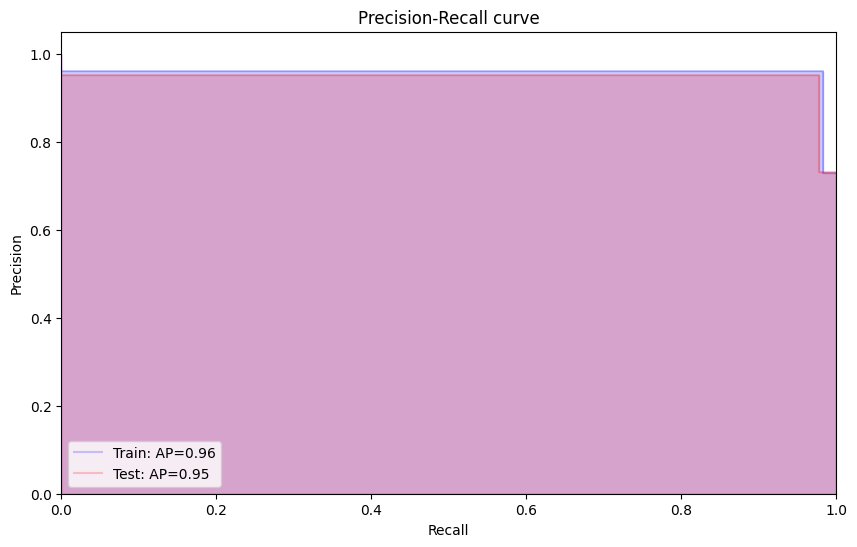

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from keras.models import load_model
y_true = []  # Label yang sebenarnya
y_pred = []  # Label hasil prediksi

for image, label in test_ds:
    predictions = loaded_model_3.predict(image,verbose=0)
    y_true.extend(label.numpy())
    y_pred.extend(np.round(predictions).flatten())

y_traintrue = []  # Label yang sebenarnya
y_trainpred = []  # Label hasil prediksi

for image, label in train_ds:
    predictions = loaded_model_3.predict(image,verbose=0)
    y_traintrue.extend(label.numpy())
    y_trainpred.extend(np.round(predictions).flatten())


# Calculate precision-recall curve for train data
precision_train, recall_train, _ = precision_recall_curve(y_traintrue, y_trainpred)
average_precision_train = average_precision_score(y_traintrue, y_trainpred)

# Calculate precision-recall curve for test data
precision_test, recall_test, _ = precision_recall_curve(y_true, y_pred)
average_precision_test = average_precision_score(y_true, y_pred)

# Plot precision-recall curve
plt.figure(figsize=(10, 6))
plt.step(recall_train, precision_train, color='b', alpha=0.2, where='post', label='Train: AP={0:0.2f}'.format(average_precision_train))
plt.fill_between(recall_train, precision_train, step='post', alpha=0.2, color='b')
plt.step(recall_test, precision_test, color='r', alpha=0.2, where='post', label='Test: AP={0:0.2f}'.format(average_precision_test))
plt.fill_between(recall_test, precision_test, step='post', alpha=0.2, color='r')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')
plt.show()


In [ ]:
def color_jitter1(image, brightness_factor=0.03, contrast_factor=0.03, seed=None):
    image = tf.image.random_brightness(image, max_delta=0.1, seed=seed)

    return image

In [ ]:
def color_jitter2(image, brightness_factor=0.03, contrast_factor=0.03, seed=None):

    image = tf.image.random_contrast(image, lower=1-contrast_factor, upper=1+contrast_factor, seed=seed)


    return image

In [ ]:
def color_jitter3(image, brightness_factor=0.03, contrast_factor=0.03, seed=None):

    image = tf.image.random_saturation(image, lower=1-contrast_factor, upper=1+contrast_factor, seed=seed)


    return image

In [ ]:
def color_jitter4(image, brightness_factor=0.03, contrast_factor=0.03, seed=None):

    image = tf.image.random_hue(image, max_delta=0.1, seed=seed)

    return image

In [ ]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('After changing saturation')
  plt.imshow(augmented)

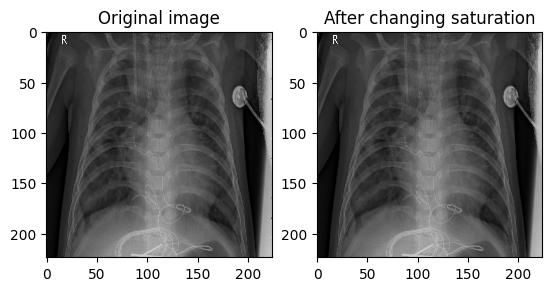

In [ ]:
image_path = '/content/chest_xray/train/PNEUMONIA/person1180_virus_2010.jpeg'
img, label = preprocess_image(image_path,'pneumonia',channels=3)
color_jiter_test = color_jitter3(img,seed=3)
visualize(img, color_jiter_test)

In [ ]:
from tensorflow.keras.layers import BatchNormalization, ReLU, Conv2D, Concatenate, Input, AvgPool2D, GlobalAvgPool2D, Dense, MaxPool2D
from tensorflow.keras.models import Model

def densenet(input_shape, numofclasses, f=32):
    repetitions = 6, 12, 24, 16

    def bn_rl_conv(x, f, k=1, s=1, p='same'):
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv2D(f, k, strides=s, padding=p)(x)
        return x

    def dense_block(tensor, r):
        for _ in range(r):
            x = bn_rl_conv(tensor, 4*f)
            x = bn_rl_conv(x, f, 3)
            tensor = Concatenate()([tensor, x])
        return tensor

    def transition_block(x):
        x = bn_rl_conv(x, K.int_shape(x)[-1] // 2)
        x = AvgPool2D(2, strides=2, padding='same')(x)
        return x

    input = Input(input_shape)

    x = Conv2D(64, 7, strides=2, padding='same')(input)
    x = MaxPool2D(3, strides=2, padding='same')(x)

    for r in repetitions:
        d = dense_block(x, r)
        x = transition_block(d)

    x = GlobalAvgPool2D()(d)

    output = Dense(1, activation='sigmoid')(x)

    model = Model(input, output)
    return model


In [ ]:
from tensorflow.keras import backend as K

In [ ]:
# Create the SqueezeNet model
input_shape= (224, 224, 3)
model = densenet(input_shape, 1)

# Display the model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_13 (Conv2D)          (None, 112, 112, 64)         9472      ['input_3[0][0]']             
                                                                                                  
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)           0         ['conv2d_13[0][0]']           
 g2D)                                                                                             
                                                                                                  
 batch_normalization_12 (Ba  (None, 56, 56, 64)           256       ['max_pooling2d_1[0][0]'] 

In [ ]:
#  learning rate
learning_rate = 0.01  # dafault 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
checkpoint_filepath6 = '/tmp/checkpoint6'
checkpoint_dir6 = os.path.dirname(checkpoint_filepath6)

callbacks_2 = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ModelCheckpoint(filepath=checkpoint_filepath6, monitor='val_loss',mode='min',
                    save_weights_only=True, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7)
]

In [ ]:
history_4= model.fit(train_ds, validation_data=val_ds,
            epochs=10,
            callbacks=callbacks_2, verbose=1)

Epoch 1/10
129/129 [==============================] - 75s 581ms/step - loss: 1.5441 - accuracy: 0.6970 - val_loss: 1565777.1250 - val_accuracy: 0.7292 - lr: 0.0100
Epoch 2/10
129/129 [==============================] - 51s 393ms/step - loss: 0.5357 - accuracy: 0.7455 - val_loss: 54.0629 - val_accuracy: 0.3288 - lr: 0.0100
Epoch 3/10
129/129 [==============================] - 50s 387ms/step - loss: 0.3578 - accuracy: 0.8441 - val_loss: 12.9828 - val_accuracy: 0.7292 - lr: 0.0100
Epoch 4/10
129/129 [==============================] - 55s 422ms/step - loss: 0.2998 - accuracy: 0.8795 - val_loss: 0.7200 - val_accuracy: 0.8294 - lr: 0.0100
Epoch 5/10
129/129 [==============================] - 50s 386ms/step - loss: 0.2657 - accuracy: 0.8953 - val_loss: 0.5003 - val_accuracy: 0.8840 - lr: 0.0100
Epoch 6/10
129/129 [==============================] - 60s 463ms/step - loss: 0.2380 - accuracy: 0.9063 - val_loss: 0.4659 - val_accuracy: 0.8817 - lr: 0.0100
Epoch 7/10
129/129 [========================

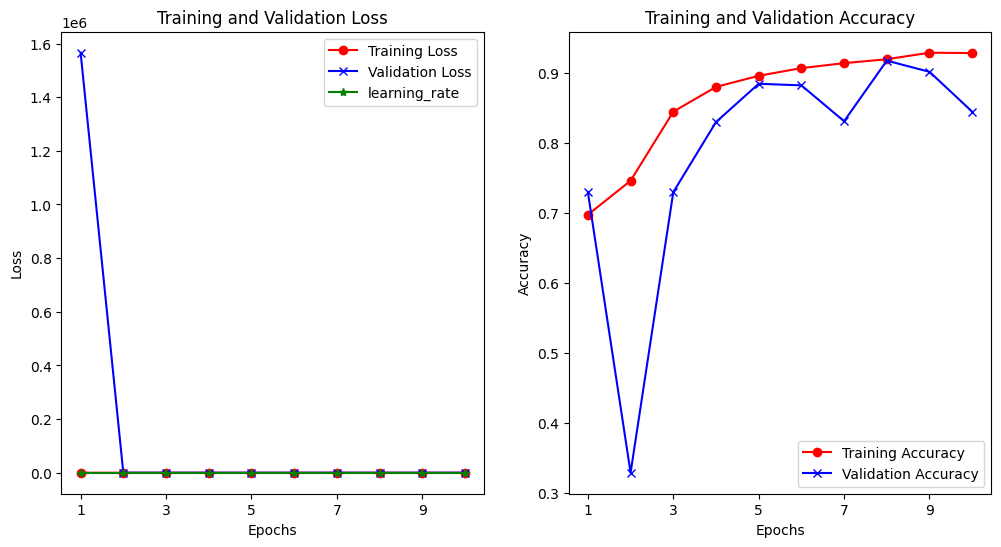

In [ ]:
plot_training_history(history_name=history_4)

In [ ]:
model.load_weights(checkpoint_filepath6)
evaluate(val_ds,model)


28/28 - 3s - loss: 0.2377 - accuracy: 0.9010 - 3s/epoch - 94ms/step
Restored model, accuracy: 90.10%
Restored model, loss: 23.77%


In [ ]:
model.load_weights(checkpoint_filepath6)
evaluate(test_ds,model)

28/28 - 10s - loss: 0.2595 - accuracy: 0.8975 - 10s/epoch - 341ms/step
Restored model, accuracy: 89.75%
Restored model, loss: 25.95%


In [ ]:
model.load_weights(checkpoint_filepath6)
evaluate(train_ds,model)

129/129 - 11s - loss: 0.2988 - accuracy: 0.8822 - 11s/epoch - 87ms/step
Restored model, accuracy: 88.22%
Restored model, loss: 29.88%


In [ ]:
model.save('model.keras')


In [ ]:
tf.keras.backend.clear_session()

In [ ]:
#Load model
loaded_model_3 = tf.keras.models.load_model('model.keras')
classification_report_result = predict_and_evaluate(loaded_model_3, test_ds)
#  classification report
print(classification_report_result)

              precision    recall  f1-score   support

      normal       0.83      0.78      0.80       237
   pneumonia       0.92      0.94      0.93       641

    accuracy                           0.90       878
   macro avg       0.88      0.86      0.87       878
weighted avg       0.90      0.90      0.90       878



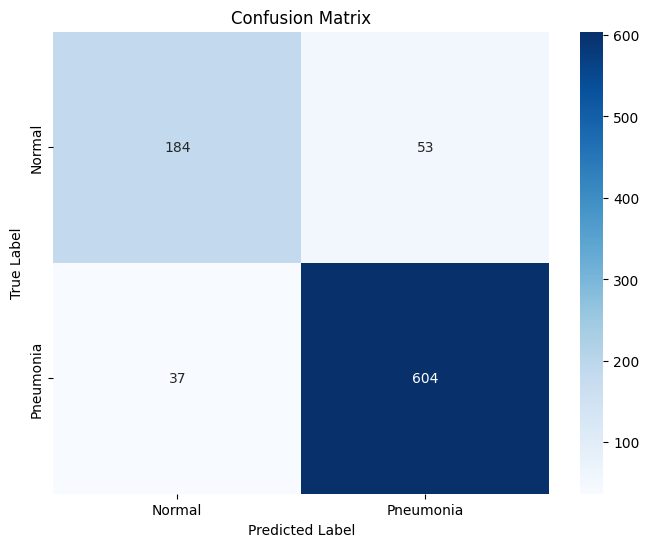

True Positive (TP): 604
False Positive (FP): 53
True Negative (TN): 184
False Negative (FN): 37


In [ ]:
# Increasing confusion matrix by model loading and dataset testing
tp, fp, tn, fn = calculate_confusion_matrix(loaded_model_3, test_ds)
print("True Positive (TP):", tp)
print("False Positive (FP):", fp)
print("True Negative (TN):", tn)
print("False Negative (FN):", fn)

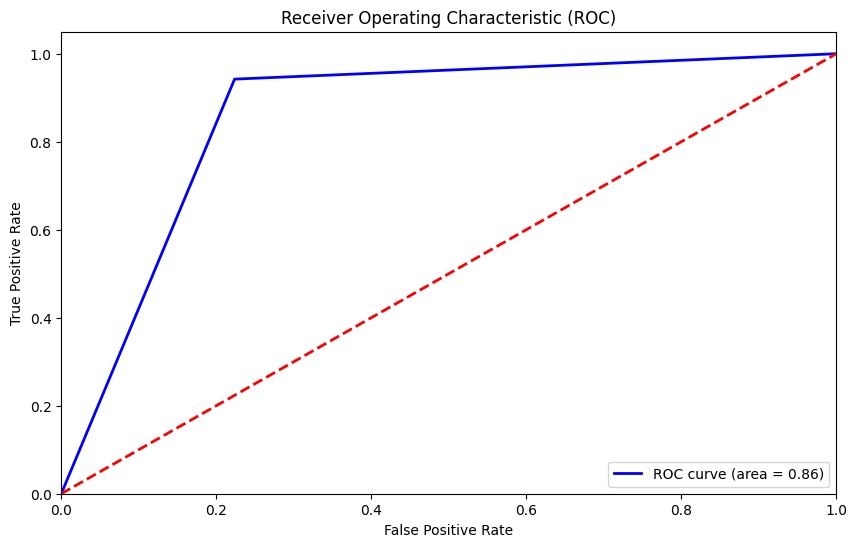

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from keras.models import load_model

y_true = []  # Label yang sebenarnya
y_pred = []  # Label hasil prediksi

for image, label in test_ds:
    predictions = loaded_model_3.predict(image,verbose=0)
    y_true.extend(label.numpy())
    y_pred.extend(np.round(predictions).flatten())

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


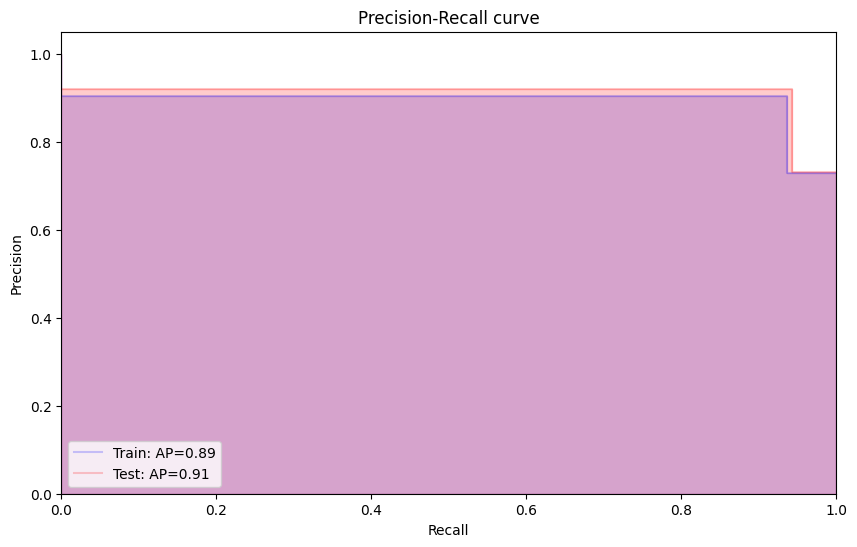

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from keras.models import load_model
y_true = []  # Label yang sebenarnya
y_pred = []  # Label hasil prediksi

for image, label in test_ds:
    predictions = loaded_model_3.predict(image,verbose=0)
    y_true.extend(label.numpy())
    y_pred.extend(np.round(predictions).flatten())

y_traintrue = []  # Label yang sebenarnya
y_trainpred = []  # Label hasil prediksi

for image, label in train_ds:
    predictions = loaded_model_3.predict(image,verbose=0)
    y_traintrue.extend(label.numpy())
    y_trainpred.extend(np.round(predictions).flatten())


# Calculate precision-recall curve for train data
precision_train, recall_train, _ = precision_recall_curve(y_traintrue, y_trainpred)
average_precision_train = average_precision_score(y_traintrue, y_trainpred)

# Calculate precision-recall curve for test data
precision_test, recall_test, _ = precision_recall_curve(y_true, y_pred)
average_precision_test = average_precision_score(y_true, y_pred)

# Plot precision-recall curve
plt.figure(figsize=(10, 6))
plt.step(recall_train, precision_train, color='b', alpha=0.2, where='post', label='Train: AP={0:0.2f}'.format(average_precision_train))
plt.fill_between(recall_train, precision_train, step='post', alpha=0.2, color='b')
plt.step(recall_test, precision_test, color='r', alpha=0.2, where='post', label='Test: AP={0:0.2f}'.format(average_precision_test))
plt.fill_between(recall_test, precision_test, step='post', alpha=0.2, color='r')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')
plt.show()
